This model takes in indian pharama data containing prices of originator drugs and their generic counter parts along with similarity scores for these compounds in order to find the possible difference in price of wegovy from the generics that will enter


/tmp/ipython-input-1031782046.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(topN["Compound Name"], rotation=90, ha="center")


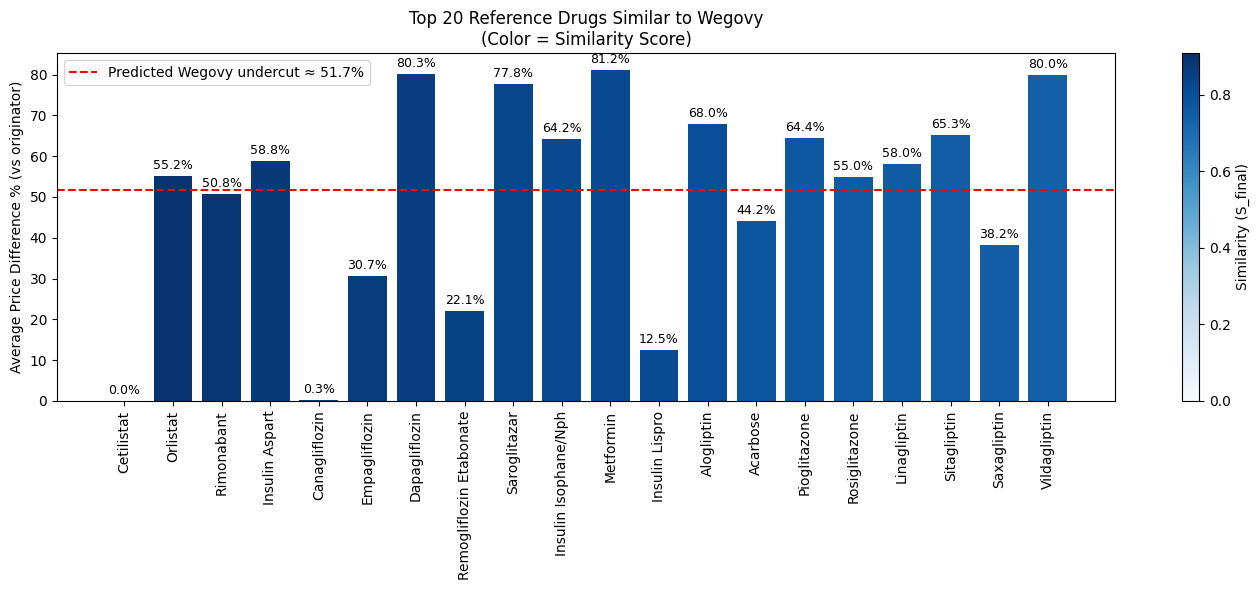

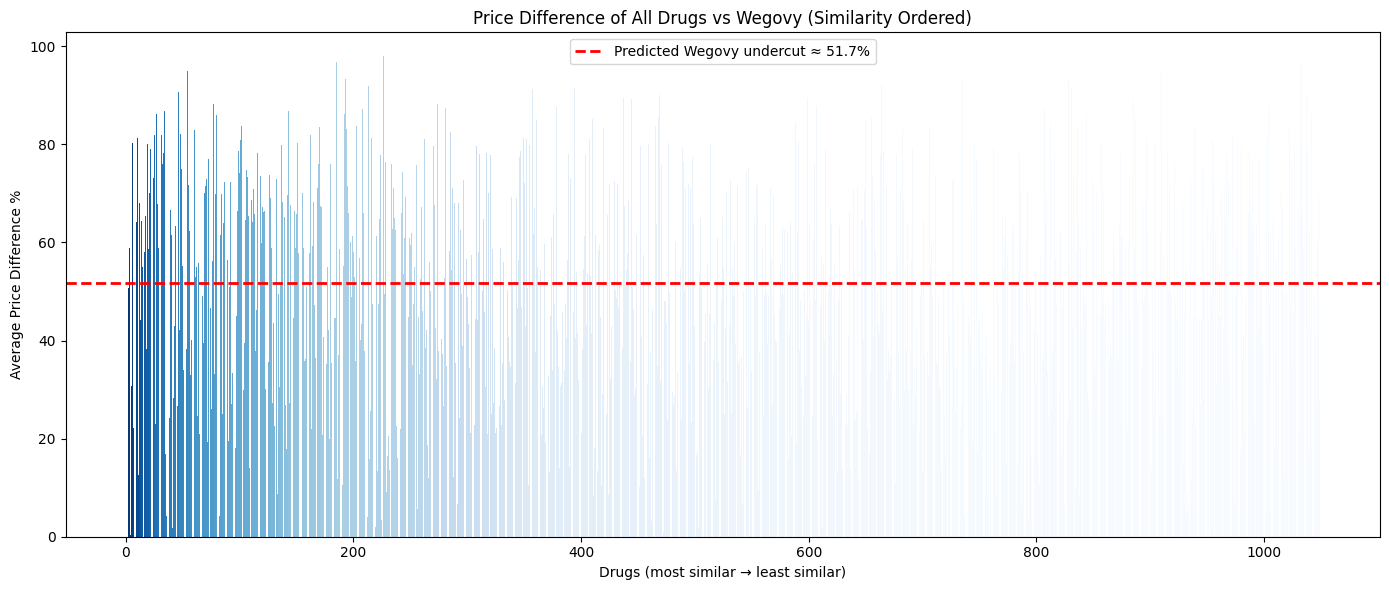

🔎 Predicted Wegovy undercut (based on all drugs): 51.7%

 Top 20 Most Similar Drugs to Wegovy:
                Compound Name             Primary Therapeutic Area   S_final  \
197                Cetilistat                              Obesity  0.908745   
716                  Orlistat                   Obesity management  0.896147   
843                Rimonabant                  Obesity (withdrawn)  0.885500   
501            Insulin Aspart                             Diabetes  0.873440   
157             Canagliflozin                      Type 2 Diabetes  0.865800   
350             Empagliflozin  Type 2 Diabetes, Heart Failure, CKD  0.863636   
265             Dapagliflozin  Type 2 Diabetes, Heart Failure, CKD  0.857598   
836   Remogliflozin Etabonate                      Type 2 diabetes  0.841573   
873              Saroglitazar    Diabetic dyslipidemia; NAFLD/NASH  0.832873   
502      Insulin Isophane/Nph                             Diabetes  0.826345   
614                 Metfo

In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load Data ---
df1 = pd.read_csv("/content/generic_vs_branded_analysis.csv")  # pricing dataset
df2 = pd.read_csv("/content/Similarity scoring final  - Start research (1).csv")  # similarity dataset

# --- Clean text for consistent merge ---
df1["ingredient_clean"] = df1["ingredient"].str.strip().str.lower()
df2["Compound_clean"] = df2["Compound Name"].str.strip().str.lower()

# --- Preprocessing ---
# Average price_difference_pct across generics per ingredient
df1_avg = df1.groupby("ingredient_clean", as_index=False).agg({
    "originator_price": "first",
    "price_difference_pct": "mean"
})

# Merge datasets on cleaned names
df = pd.merge(df1_avg, df2, left_on="ingredient_clean", right_on="Compound_clean")

# --- Wegovy reference price (fixed to ₹5500) ---
wegovy_price = 5500

# --- Similarity Calculation ---
# 1. Price similarity
df["S_price"] = 1 - abs(df["originator_price"] - wegovy_price) / wegovy_price
df["S_price"] = df["S_price"].clip(lower=0)

# 2. Disease similarity (dominant factor)
df["S_disease"] = df["Disease similarity"]
df["S_disease"] = (df["S_disease"] - df["S_disease"].min()) / (df["S_disease"].max() - df["S_disease"].min())

# 3. Mechanism similarity (TASS only, MANS ignored)
df["S_tass"] = df["TASS Score"]
df["S_tass"] = (df["S_tass"] - df["S_tass"].min()) / (df["S_tass"].max() - df["S_tass"].min())

# --- Final Similarity Score (weighted) ---
df["S_final"] = (
    0.7 * df["S_disease"] +   # heavier weight
    0.2 * df["S_tass"] +
    0.1 * df["S_price"]
)

# Fill missing values
df["S_final"] = df["S_final"].fillna(0)
df["price_difference_pct"] = df["price_difference_pct"].fillna(0)

# --- Prediction: Weighted average (all drugs) ---
if df["S_final"].sum() > 0:
    predicted_undercut = np.average(
        df["price_difference_pct"],
        weights=df["S_final"]
    )
else:
    predicted_undercut = df["price_difference_pct"].mean()

predicted_undercut = np.clip(predicted_undercut, 0, 100)

# --- Select Top 20 Most Similar for display ---
topN = df.sort_values("S_final", ascending=False).head(20)

# --- Visualization 1: Top 20 bar chart ---
plt.figure(figsize=(14,6))
ax = plt.gca()
norm_sim = (topN["S_final"] - df["S_final"].min()) / (df["S_final"].max() - df["S_final"].min())
bars = ax.bar(topN["Compound Name"], topN["price_difference_pct"], color=plt.cm.Blues(norm_sim))

# Colorbar
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=df["S_final"].min(), vmax=df["S_final"].max()))
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Similarity (S_final)")

# Annotate bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1, f"{height:.1f}%", ha='center', va='bottom', fontsize=9)

ax.axhline(predicted_undercut, color="red", linestyle="--", linewidth=1.5,
           label=f"Predicted Wegovy undercut ≈ {predicted_undercut:.1f}%")
ax.set_xticklabels(topN["Compound Name"], rotation=90, ha="center")
ax.set_ylabel("Average Price Difference % (vs originator)")
ax.set_title("Top 20 Reference Drugs Similar to Wegovy\n(Color = Similarity Score)")
ax.legend()
plt.tight_layout()
plt.show()

# --- Visualization 2: Histogram of all drugs ---
plt.figure(figsize=(14,6))
df_sorted = df.sort_values("S_final", ascending=False)
plt.bar(range(len(df_sorted)), df_sorted["price_difference_pct"], color=plt.cm.Blues(
    (df_sorted["S_final"] - df["S_final"].min()) / (df["S_final"].max() - df["S_final"].min())
))
plt.axhline(predicted_undercut, color="red", linestyle="--", linewidth=2,
            label=f"Predicted Wegovy undercut ≈ {predicted_undercut:.1f}%")
plt.xlabel("Drugs (most similar → least similar)")
plt.ylabel("Average Price Difference %")
plt.title("Price Difference of All Drugs vs Wegovy (Similarity Ordered)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Print Final Insights ---
print("🔎 Predicted Wegovy undercut (based on all drugs): "
      f"{predicted_undercut:.1f}%\n")
print(" Top 20 Most Similar Drugs to Wegovy:")
print(topN[["Compound Name", "Primary Therapeutic Area", "S_final", "price_difference_pct"]])



This looks at competitor count of drugs similar to wegovy and calculates potential number of competitors for wegovy

/tmp/ipython-input-2110823566.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(topN["Compound Name"], rotation=90, ha="center")


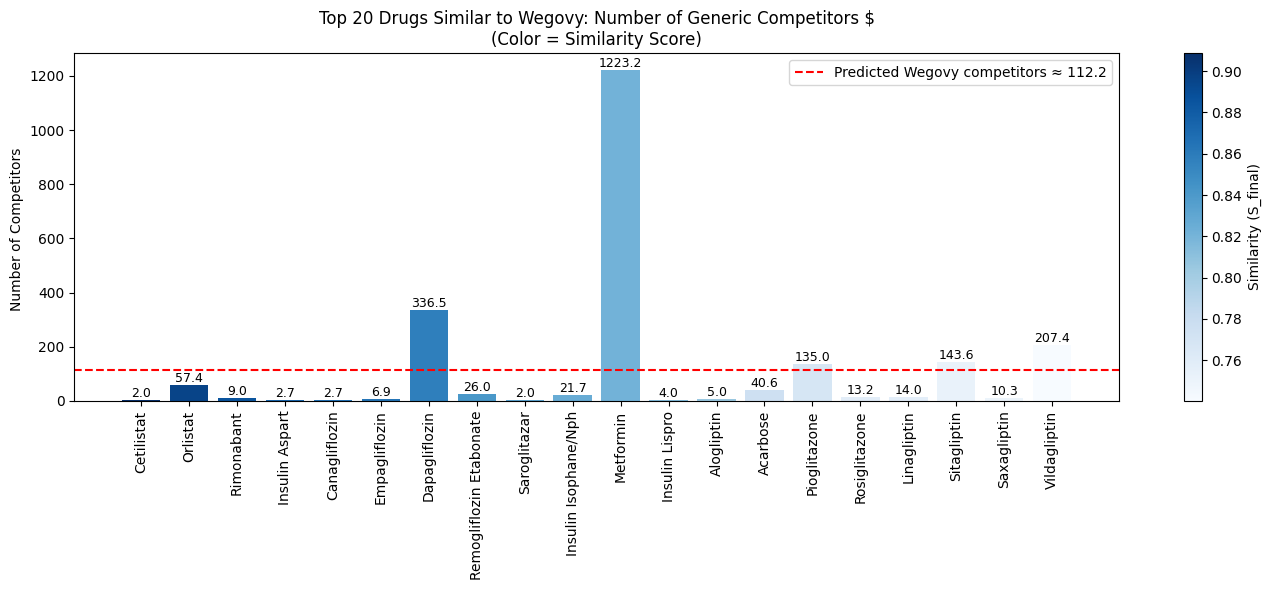

In [13]:
# --- Aggregate df1 including num_competitors correctly ---
df1_avg = df1.groupby("ingredient_clean", as_index=False).agg({
    "originator_price": "first",
    "price_difference_pct": "mean",
    "num_competitors": "mean"   # proper aggregation
})
df1_avg["num_competitors"] = df1_avg["num_competitors"].fillna(0)

# --- Merge with similarity dataset ---
df = pd.merge(df1_avg, df2, left_on="ingredient_clean", right_on="Compound_clean")

# --- Compute similarity scores ---
df["S_price"] = 1 - abs(df["originator_price"] - wegovy_price) / wegovy_price
df["S_price"] = df["S_price"].clip(lower=0)

df["S_disease"] = (df["Disease similarity"] - df["Disease similarity"].min()) / \
                  (df["Disease similarity"].max() - df["Disease similarity"].min())

df["S_tass"] = (df["TASS Score"] - df["TASS Score"].min()) / \
               (df["TASS Score"].max() - df["TASS Score"].min())

df["S_final"] = 0.7 * df["S_disease"] + 0.2 * df["S_tass"] + 0.1 * df["S_price"]
df["S_final"] = df["S_final"].fillna(0)

# --- Select Top 20 Most Similar ---
topN = df.sort_values("S_final", ascending=False).head(20)
topN["num_competitors"] = topN["num_competitors"].fillna(0)

# --- Remove rows where num_competitors > 5 ---
#topN = topN[topN["num_competitors"] <= 5]

# --- Weighted predicted number of competitors for Wegovy ---
predicted_competitors = np.average(topN["num_competitors"], weights=topN["S_final"])

# --- Plot Top 20 Number of Competitors ---
plt.figure(figsize=(14,6))
ax = plt.gca()
norm_sim = (topN["S_final"] - topN["S_final"].min()) / (topN["S_final"].max() - topN["S_final"].min())
bars = ax.bar(topN["Compound Name"], topN["num_competitors"], color=plt.cm.Blues(norm_sim))

# Colorbar
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=topN["S_final"].min(), vmax=topN["S_final"].max()))
sm.set_array(topN["S_final"])  # <-- set actual array
plt.colorbar(sm, ax=ax, label="Similarity (S_final)")  # <-- specify ax

# Annotate bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.2, f"{height:.1f}", ha='center', va='bottom', fontsize=9)

# Red dashed line
ax.axhline(predicted_competitors, color="red", linestyle="--", linewidth=1.5,
           label=f"Predicted Wegovy competitors ≈ {predicted_competitors:.1f}")

ax.set_xticklabels(topN["Compound Name"], rotation=90, ha="center")
ax.set_ylabel("Number of Competitors ")
ax.set_title("Top 20 Drugs Similar to Wegovy: Number of Generic Competitors $\n(Color = Similarity Score)")
ax.legend()
plt.tight_layout()
plt.show()


Confidence interval calculation

In [14]:
# --- Bootstrap Confidence Interval for Predicted Undercut ---
boot_preds = []
n_boot = 10000  # number of bootstrap samples

for _ in range(n_boot):
    sample = df.sample(frac=1, replace=True)
    if sample["S_final"].sum() > 0:
        boot_pred = np.average(sample["price_difference_pct"], weights=sample["S_final"])
    else:
        boot_pred = sample["price_difference_pct"].mean()
    boot_preds.append(boot_pred)

# 95% CI bounds
lower_bound, upper_bound = np.percentile(boot_preds, [2.5, 97.5])
print(f"95% CI for Wegovy undercut: {lower_bound:.1f}% – {upper_bound:.1f}%")


95% CI for Wegovy undercut: 49.2% – 54.1%


Plotting the confidence interval

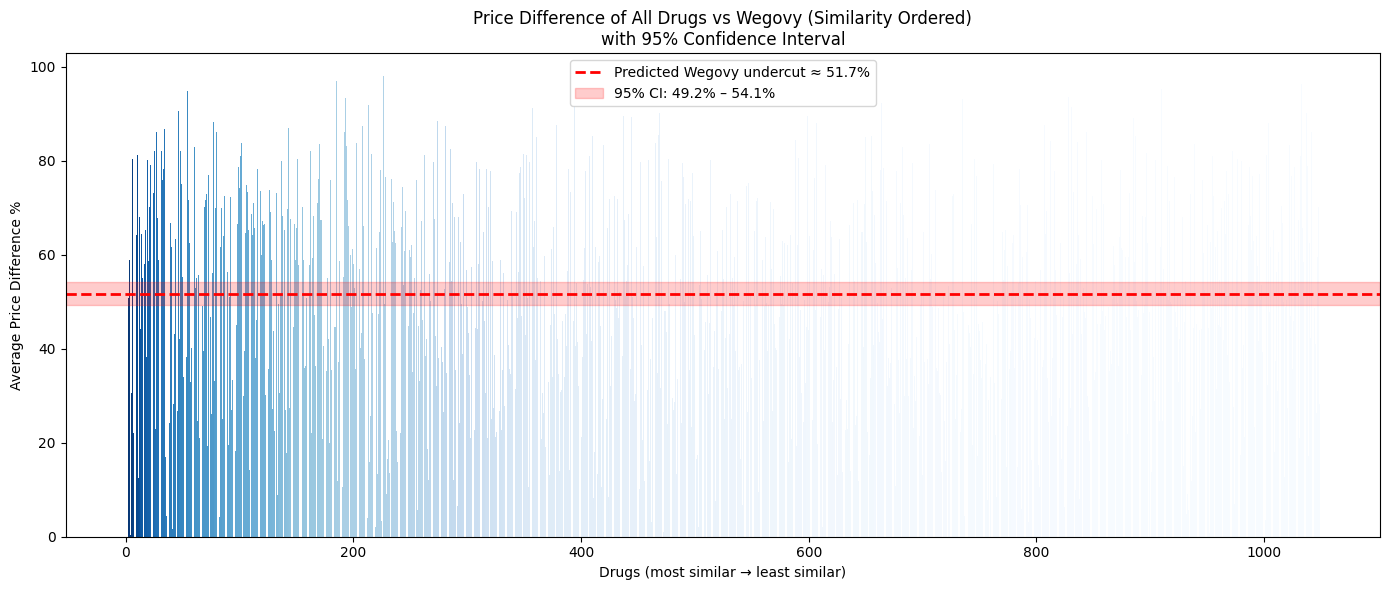

In [15]:
# --- Visualization 2: Histogram of all drugs with CI band ---
plt.figure(figsize=(14,6))
df_sorted = df.sort_values("S_final", ascending=False)

plt.bar(
    range(len(df_sorted)),
    df_sorted["price_difference_pct"],
    color=plt.cm.Blues(
        (df_sorted["S_final"] - df["S_final"].min()) /
        (df["S_final"].max() - df["S_final"].min())
    )
)

# Mean predicted undercut line
plt.axhline(predicted_undercut, color="red", linestyle="--", linewidth=2,
            label=f"Predicted Wegovy undercut ≈ {predicted_undercut:.1f}%")

# Confidence interval band
plt.axhspan(lower_bound, upper_bound, color="red", alpha=0.2,
            label=f"95% CI: {lower_bound:.1f}% – {upper_bound:.1f}%")

plt.xlabel("Drugs (most similar → least similar)")
plt.ylabel("Average Price Difference %")
plt.title("Price Difference of All Drugs vs Wegovy (Similarity Ordered)\nwith 95% Confidence Interval")
plt.legend()
plt.tight_layout()
plt.show()


Formally plotting both findings

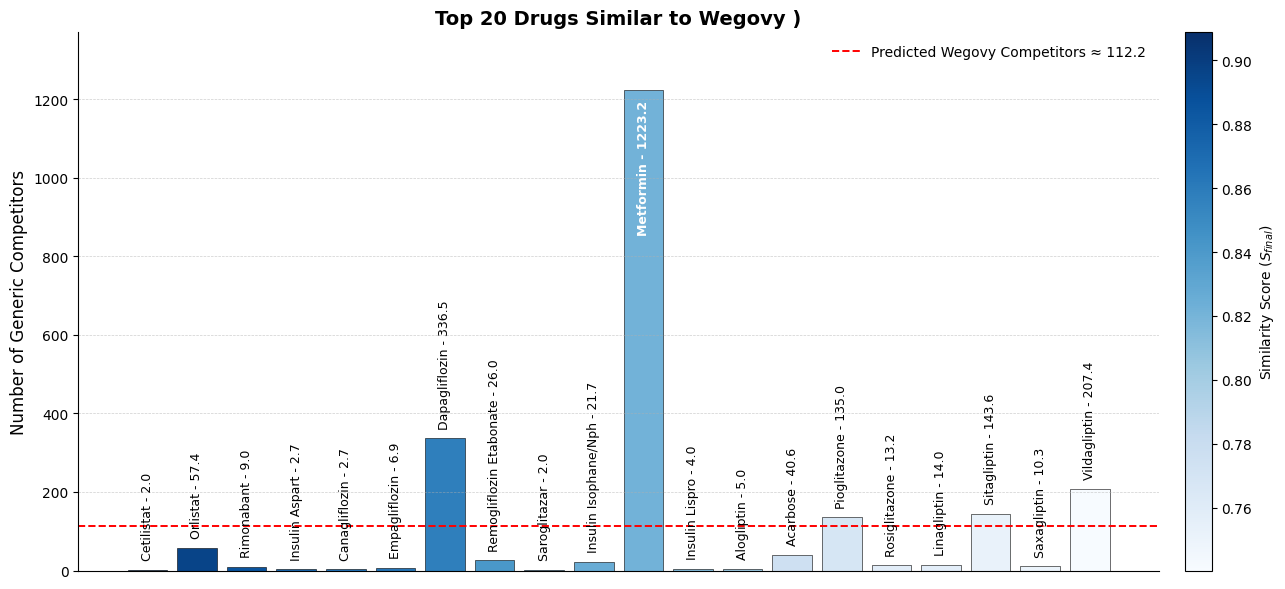

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data
drugs = ["Cetilistat", "Orlistat", "Rimonabant", "Insulin Aspart", "Canagliflozin",
         "Empagliflozin", "Dapagliflozin", "Remogliflozin Etabonate", "Saroglitazar",
         "Insulin Isophane/Nph", "Metformin", "Insulin Lispro", "Alogliptin", "Acarbose",
         "Pioglitazone", "Rosiglitazone", "Linagliptin", "Sitagliptin", "Saxagliptin", "Vildagliptin"]

competitors = [2.0, 57.4, 9.0, 2.7, 2.7, 6.9, 336.5, 26.0, 2.0,
               21.7, 1223.2, 4.0, 5.0, 40.6, 135.0, 13.2, 14.0, 143.6, 10.3, 207.4]

# similarity (S_final) from your table
s_final = [0.908745, 0.896147, 0.885500, 0.873440, 0.865800, 0.863636, 0.857598,
           0.841573, 0.832873, 0.826345, 0.821818, 0.814709, 0.805595, 0.775822,
           0.768109, 0.758610, 0.757273, 0.752258, 0.749927, 0.740364]

df = pd.DataFrame({"Drug": drugs, "Competitors": competitors, "S_final": s_final})

# Ensure higher similarity -> darker color
norm = plt.Normalize(vmin=df["S_final"].min(), vmax=df["S_final"].max())
cmap = plt.cm.Blues
colors = cmap(norm(df["S_final"]))

predicted_value = 112.2
y_max = df["Competitors"].max()
inside_threshold = 0.60 * y_max  # change this if you want more/less labels placed inside

fig, ax = plt.subplots(figsize=(14,6))
bars = ax.bar(df["Drug"], df["Competitors"], color=colors, edgecolor="black", linewidth=0.4)

# Predicted horizontal line
ax.axhline(y=predicted_value, color="red", linestyle="--", linewidth=1.4, label=f"Predicted Wegovy Competitors ≈ {predicted_value}")

# Remove bottom x labels (we put names above bars)
ax.set_xticks([])
ax.set_ylim(0, y_max * 1.12)

# Put "Compound - #Competitors" vertically above bars or inside large bars
for bar, drug, comp in zip(bars, df["Drug"], df["Competitors"]):
    height = bar.get_height()
    label_text = f"{drug} - {comp:.1f}"
    x = bar.get_x() + bar.get_width() / 2.0
    if height >= inside_threshold:
        # label inside bar (near top) — white for contrast
        y = height - 0.02 * y_max
        ax.text(x, y, label_text, ha="center", va="top", rotation=90, color="white", fontsize=9, weight="bold")
    else:
        # label above bar
        y = height + 0.02 * y_max
        ax.text(x, y, label_text, ha="center", va="bottom", rotation=90, color="black", fontsize=9)

# Aesthetics
ax.set_ylabel("Number of Generic Competitors", fontsize=12)
ax.set_title("Top 20 Drugs Similar to Wegovy )", fontsize=14, weight="bold")
ax.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
ax.legend(frameon=False)

# Colorbar with correct mapping (darker = higher similarity)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Similarity Score ($S_{final}$)")

plt.tight_layout()
plt.show()


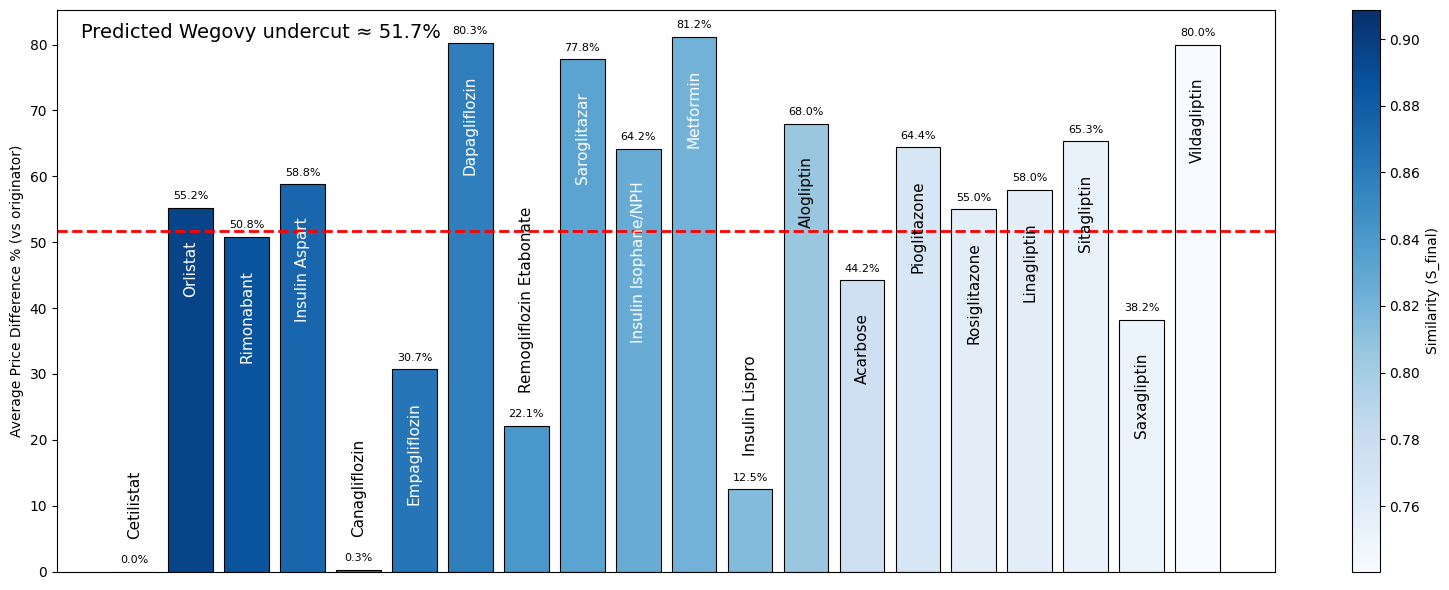

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Data
compounds = [
    "Cetilistat", "Orlistat", "Rimonabant", "Insulin Aspart", "Canagliflozin", "Empagliflozin",
    "Dapagliflozin", "Remogliflozin Etabonate", "Saroglitazar", "Insulin Isophane/NPH",
    "Metformin", "Insulin Lispro", "Alogliptin", "Acarbose", "Pioglitazone", "Rosiglitazone",
    "Linagliptin", "Sitagliptin", "Saxagliptin", "Vildagliptin"
]

values = [
    0.0, 55.2, 50.8, 58.8, 0.3, 30.7, 80.3, 22.1, 77.8, 64.2,
    81.2, 12.5, 68.0, 44.2, 64.4, 55.0, 58.0, 65.3, 38.2, 80.0
]

# Actual similarity scores
similarity = [
    0.9087, 0.8961, 0.8855, 0.8734, 0.8658, 0.8636, 0.8576, 0.8416, 0.8329, 0.8263,
    0.8218, 0.8147, 0.8056, 0.7758, 0.7681, 0.7586, 0.7573, 0.7523, 0.7499, 0.7404
]

x = np.arange(len(compounds))
fig, ax = plt.subplots(figsize=(16, 6))

# Bars with border + shading by similarity
cmap = plt.cm.Blues
norm = plt.Normalize(min(similarity), max(similarity))
colors = cmap(norm(similarity))
bars = ax.bar(x, values, color=colors, edgecolor="black", linewidth=0.8)

# Compound name placement
for i, (bar, label) in enumerate(zip(bars, compounds)):
    height = bar.get_height()

    # Special case: Etabonate → always outside in black
    if label == "Remogliflozin Etabonate":
        ax.text(bar.get_x() + bar.get_width()/2, height + 5, label,
                ha="center", va="bottom", color="black", fontsize=11, rotation=90)

    # For bars after Insulin Lispro → force black text
    elif i >= 11:
        ax.text(bar.get_x() + bar.get_width()/2, height - 5 if height > 20 else height + 5, label,
                ha="center", va="top" if height > 20 else "bottom", color="black", fontsize=11, rotation=90)

    # Normal placement (before Lispro)
    elif height > 20:  # Tall → inside (white)
        ax.text(bar.get_x() + bar.get_width()/2, height - 5, label,
                ha="center", va="top", color="white", fontsize=11, rotation=90)
    else:  # Short → outside (black)
        ax.text(bar.get_x() + bar.get_width()/2, height + 5, label,
                ha="center", va="bottom", color="black", fontsize=11, rotation=90)

# Percentage labels
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 1, f"{val:.1f}%",
            ha="center", va="bottom", color="black", fontsize=8)

# Undercut line (thicker, red)
undercut = 51.7
ax.axhline(undercut, color="red", linestyle="--", linewidth=2)

# Annotation (black text only, no box)
ax.text(0.02, 0.95, f"Predicted Wegovy undercut ≈ {undercut:.1f}%",
        transform=ax.transAxes, fontsize=14, color="black")

# Style
ax.set_xticks([])
ax.set_ylabel("Average Price Difference % (vs originator)")

# Colorbar showing similarity mapping
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(similarity)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Similarity (S_final)")

plt.tight_layout()
plt.show()
